In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
from scipy import signal

In [2]:
# routines
def _shift(pair,shift):
    """shift t1 shift/2 samples to the left and
       shift t2 shift/2 samples to the right,
       if shift is odd move t1 the extra sample
       this process truncates trace length"""
    if shift == 0:
        return pair
    elif shift == 1:
        t1 = pair[0,:]
        t2 = pair[1,:]
        return np.vstack((t1[math.ceil(shift/2):], t2[:-shift]))
    else:
        t1 = pair[0,:]
        t2 = pair[1,:]
        return np.vstack((t1[math.ceil(shift/2):-math.floor(shift/2)], t2[:-shift]))

def _rotate(pair,degrees):
    """t1 is x-axis and t2 is y-axis,
       rotates clockwise"""
    ang = np.deg2rad(degrees)
    rot = np.array([[np.cos(ang),-np.sin(ang)],
                    [np.sin(ang), np.cos(ang)]])
    return np.dot(rot,pair)

def _rotate_and_shift(pair,degrees,shift):
    return _shift(_rotate(pair,degrees), shift)

def _split(pair,degrees,shift):
    return _rotate(_shift(_rotate(pair,degrees), shift),-degrees)

def _unsplit(pair,degrees,shift):
    return _split(pair,degrees+90,shift)
    
def _taper(pair,width,centre=None):
    """Apply Hanning window about c0 sample
       of width number of samples, truncates traces"""
    
    if centre is None:
        centre = math.floor(pair.shape[1]/2)
        
    if width > pair.shape[1]:
        raise Exception('taper width is greater than trace length')
        
    t0 = centre - math.floor(width/2)
    t1 = centre + math.ceil(width/2)
    
    if t0 < 0:
        raise Exception('window starts before trace data')
    elif t1 > pair.shape[1]:
        raise Exception('window ends after trace data')
        
    return np.hanning(width) * pair[:,t0:t1]

def _eigcov(pair):
    return np.sort(np.linalg.eigvals(np.cov(pair,rowvar=True)))
#     return np.sort(np.linalg.eigvals(np.cov(pair)))

def _grideigcov(pair,maxshift,window=None, stepang=None,stepshift=None):
    
    # set some defaults
    if stepshift is None:
        stepshift = int(np.max([1,maxshift/40]))
    if stepang is None:
        stepang = 2
    if window is None:
        # by default whatevers smaller,
        # half trace length or 10 * max shift
        window = int(np.min([pair.shape[1] * 0.5,maxshift * 10]))
    
    deg, shift = np.meshgrid(np.arange(0,180,stepang),
                             np.arange(0,maxshift,stepshift).astype(int))
    
    shape = deg.shape
    lam1 = np.zeros(shape)
    lam2 = np.zeros(shape)
    for ii in np.arange(shape[1]):
        temp = _rotate(pair,deg[0,ii]+90)
        for jj in np.arange(shape[0]):
            temp2 = _shift(temp,shift[jj,ii])
            temp3 = _taper(temp2,window)
            lam2[jj,ii], lam1[jj,ii] = _eigcov(temp3)
    return deg, shift, lam1, lam2

def _xcorr(pair):
    return np.correlate(pair[0,:],pair[1,:])[0]

def _gridxcorr(pair,maxshift,window=None, stepang=None,stepshift=None):
    
    # set some defaults
    if stepshift is None:
        stepshift = int(np.max([1,maxshift/40]))
    if stepang is None:
        stepang = 2
    if window is None:
        # by default whatevers smaller,
        # half trace length or 10 * max shift
        window = int(np.min([pair.shape[1] * 0.5,maxshift * 10]))
        
    deg, shift = np.meshgrid(np.arange(0,180,stepang),
                             np.arange(0,maxshift,stepshift).astype(int))
    
    shape = deg.shape
    xc = np.zeros(shape)
    for ii in np.arange(shape[1]):
        temp = _rotate(pair,deg[0,ii]+90)
        for jj in np.arange(shape[0]):
            temp2 = _shift(temp,shift[jj,ii])
            temp3 = _taper(temp2,window)
            xc[jj,ii] = _xcorr(temp3)
    return deg, shift, xc 

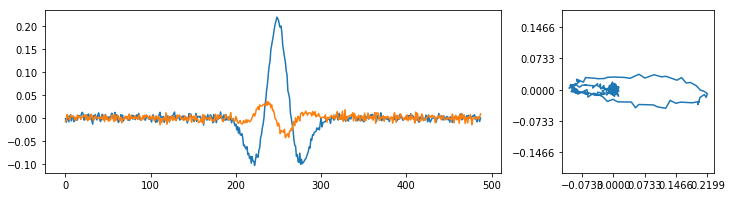

In [3]:
# synthetic data
ricker = signal.ricker(500, 16.0)
pair = np.vstack((ricker,np.zeros(ricker.shape)))
noise = np.random.normal(0,.005,pair.shape)
splitdata = _split(pair+noise,110,12)

def plt_pair(pair):
    from matplotlib import gridspec
    fig = plt.figure(figsize=(12, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.plot(pair.T)
    ax1 = plt.subplot(gs[1])
    ax1.plot(pair[0,:],pair[1,:])
    ticks = np.linspace(-np.abs(pair).max(),np.abs(pair).max(),7)
    ax1.xaxis.set_ticks(ticks)
    ax1.yaxis.set_ticks(ticks)
    plt.axis('equal')
    plt.show()
    
plt_pair(splitdata)

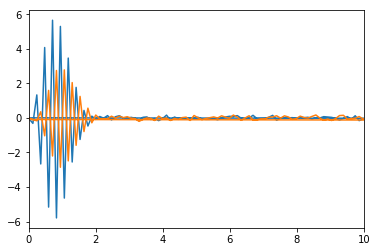

In [4]:
t1 = splitdata[0,:]
sp = np.fft.fft(t1)
freq = np.rad2deg(np.fft.fftfreq(t1.shape[-1]))
plt.plot(freq, sp.real, freq, sp.imag)
plt.xlim(0,10)
plt.show()

In [9]:
np.fft.fft?

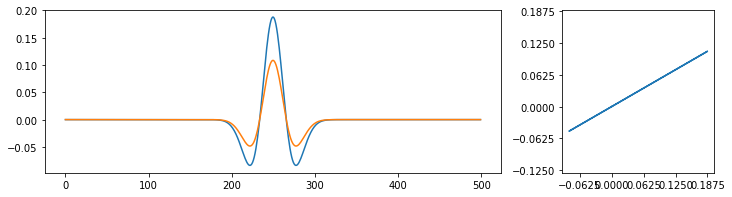

In [5]:
plt_pair(_rotate(pair,30))

In [6]:
f1 = np.fft.fft(pair[0,:])
f2 = np.fft.fft(pair[1,:])

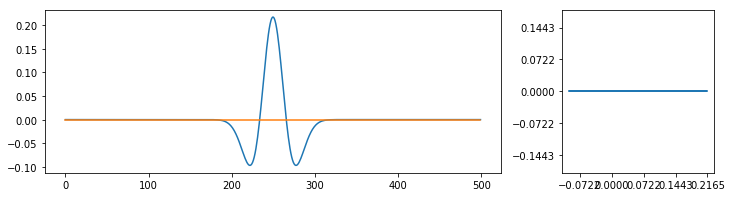

In [7]:
# Forward and reverse Fourier Transform
plt_pair(np.vstack((np.real(np.fft.ifft(f1)),
                            np.real(np.fft.ifft(f2)))))

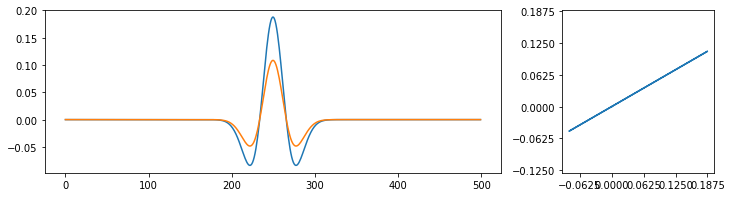

In [8]:
# Rotation in Fourier Domain
rf = _rotate(np.vstack((f1,f2)),30)
data = np.vstack((np.real(np.fft.ifft(rf[0,:])),
                  np.real(np.fft.ifft(rf[1,:]))))
plt_pair(data)

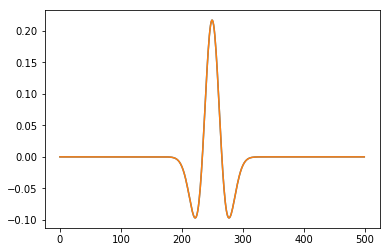

In [9]:
# Shift in the Fourier Domain
# t1 = _taper(splitdata,100)[0,:]
t1 = pair[0,:]
f1 = np.fft.fft(t1)
delta = 1
# shift must be an integer multiple of delta
shift = 0
N = f1.size
P = np.arange(N) * -(2*np.pi * shift)/(delta * N)  
fs = f1 * np.exp(1j*P)
t2 = np.real(np.fft.ifft(fs))
plt.plot(t1)
plt.plot(t2)
# plt.plot(fs.real)
# plt.plot(fs.imag)
# freq = np.rad2deg(np.fft.fftfreq(t1.shape[-1]))
# plt.plot(freq, f1.real, freq, f1.imag)
# plt.xlim(0,4)
# plt.show()


In [87]:
# a = np.array([1,2])
b = np.array([np.pi,np.pi/2])
np.cos(b) + np.sin(b)*1j

array([ -1.00000000e+00 +1.22464680e-16j,   6.12323400e-17 +1.00000000e+00j])

In [234]:
np.cov(t1,t2)

array([[ 0.00200401,  0.00097217],
       [ 0.00097217,  0.00200401]])

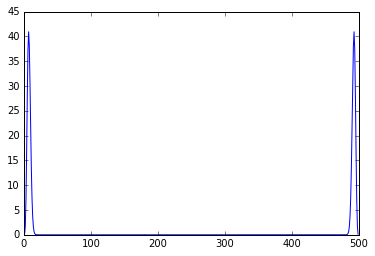

In [247]:
plt.plot(np.abs(f1)**2)

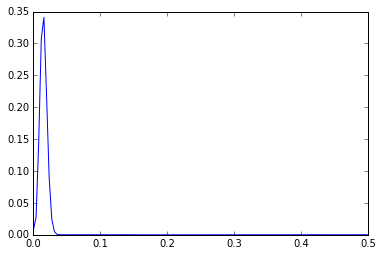

In [250]:
from scipy.signal import welch
f, psd = welch(splitdata[0,:],
               fs=1.,  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant') # detrend x by subtracting the mean
plt.plot(f,psd)

In [10]:
import splitwavepy as sw

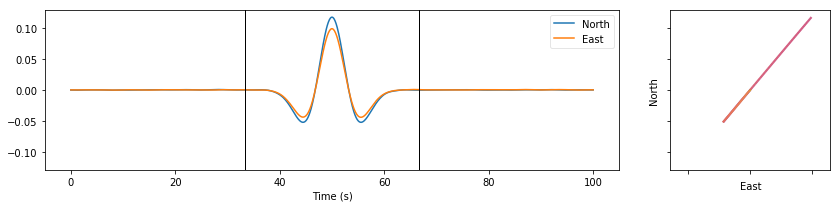

In [60]:
a = sw.SplitWave(pol=40)
a.plot()

In [209]:
# get fourier traces
x = a.x[:-1]
y = a.y[:-1]
x = x - np.mean(x)
y = y - np.mean(y)
fx = np.fft.fft(x)
fy = np.fft.fft(y)

In [210]:
cxy = fx*fy.conj()
cyx = fy*fx.conj()
cxx = fx*fx.conj()
cyy = fy*fy.conj()

In [211]:
ixy = np.fft.ifft(cxy)
iyx = np.fft.ifft(cyx)
ixx = np.fft.ifft(cxx)
iyy = np.fft.ifft(cyy)

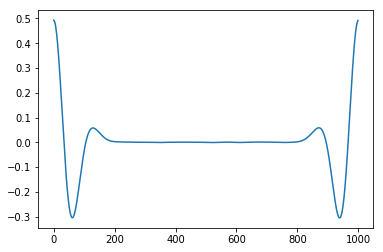

In [212]:
# plt.plot(np.real(ixx))
# plt.plot(np.real(iyy))
plt.plot(ixy.real)

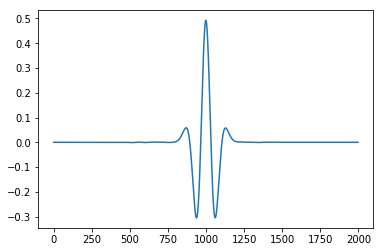

In [213]:
plt.plot(np.correlate(x,y,mode='full'))

In [214]:
# raw correlation coefficient difference between
# fourier method V time domain method
ixy.real[0] - np.correlate(x,y)

array([ -5.55111512e-17])

In [216]:
# Pearson Correlation in time domain
np.correlate(x, y)/(x.size * np.std(x) * np.std(y)) - np.corrcoef(x, y)[0,1]

array([ -1.11022302e-16])

In [219]:
# np.corrcoef(a.x, a.y)
np.var(x)*(x.size) - ixx.real[0]

1.1102230246251565e-16

In [222]:
n = x.size
((ixy.real / ixy.size) / \
 (np.sqrt(ixx/ixx.size) * np.sqrt(iyy/iyy.size))).real

array([  9.99925535e-01,   1.00004252e+00,   1.00016052e+00,
         1.00028012e+00,   1.00040194e+00,   1.00052663e+00,
         1.00065487e+00,   1.00078738e+00,   1.00092498e+00,
         1.00106856e+00,   1.00121914e+00,   1.00137791e+00,
         1.00154621e+00,   1.00172565e+00,   1.00191816e+00,
         1.00212604e+00,   1.00235210e+00,   1.00259982e+00,
         1.00287356e+00,   1.00317885e+00,   1.00352282e+00,
         1.00391487e+00,   1.00436759e+00,   1.00489833e+00,
         1.00553165e+00,   1.00630353e+00,   1.00726887e+00,
         1.00851597e+00,   1.01019636e+00,   1.01259400e+00,
         1.01631030e+00,   1.02288035e+00,   1.03773448e+00,
         1.10400785e+00,   8.57490738e-01,   9.57435441e-01,
         9.74920811e-01,   9.82217322e-01,   9.86235921e-01,
         9.88790291e-01,   9.90564688e-01,   9.91874670e-01,
         9.92885950e-01,   9.93693900e-01,   9.94357294e-01,
         9.94914323e-01,   9.95390882e-01,   9.95805144e-01,
         9.96170242e-01,

In [189]:
ixy.real / ixy.size

array([ 0.00049218,  0.00049163,  0.00048989, ...,  0.00048661,
        0.00048966,  0.00049152])

In [148]:
ixx.real[0]

0.586322878010479

In [170]:
np.correlate(a.x, a.x)

array([ 0.58632288])

In [169]:
np.var(a.x)*(a.x.size)

0.58632152133470516

In [203]:
np.abs(ixx)

array([  5.86322868e-01,   5.85608256e-01,   5.83466894e-01,
         5.79906088e-01,   5.74937978e-01,   5.68579488e-01,
         5.60852245e-01,   5.51782488e-01,   5.41400952e-01,
         5.29742730e-01,   5.16847123e-01,   5.02757468e-01,
         4.87520947e-01,   4.71188389e-01,   4.53814048e-01,
         4.35455370e-01,   4.16172753e-01,   3.96029288e-01,
         3.75090499e-01,   3.53424063e-01,   3.31099537e-01,
         3.08188068e-01,   2.84762101e-01,   2.60895092e-01,
         2.36661209e-01,   2.12135038e-01,   1.87391290e-01,
         1.62504512e-01,   1.37548801e-01,   1.12597521e-01,
         8.77230302e-02,   6.29964162e-02,   3.84872385e-02,
         1.42632820e-02,   9.60967749e-03,   3.30680958e-02,
         5.60508700e-02,   7.84995336e-02,   1.00358437e-01,
         1.21574912e-01,   1.42099424e-01,   1.61885699e-01,
         1.80890848e-01,   1.99075460e-01,   2.16403687e-01,
         2.32843307e-01,   2.48365779e-01,   2.62946264e-01,
         2.76563650e-01,